In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
import numpy as np
import pandas as pd
import datetime
#from adbrew_core.settings import db
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [86]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)

In [87]:
a = list(df['accountId'].unique())

In [88]:
df = df[df['accountId']=="5ffdb895b08512986422b08c"]

In [89]:
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [90]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:20]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [91]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

In [92]:
account_data

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
0,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-20,3636.560000,1234.360000,143,18528,7,8.631888
1,5ffdb895b08512986422b08c,6055910382152,49896973267574,24104861481597,2022-01-20,4575.420000,394.890000,63,7284,1,6.268095
2,5ffdb895b08512986422b08c,40670175184901,177037018948030,234598292844815,2022-01-20,8038.130000,560.930000,77,6534,14,7.284805
3,5ffdb895b08512986422b08c,135924847805717,100926924880433,79454459707340,2022-01-20,16706.330000,348.980000,142,3947,27,2.457606
4,5ffdb895b08512986422b08c,29667499780453,85722658525534,85472206701258,2022-01-20,2625.420000,1910.220000,96,26074,3,19.898125
...,...,...,...,...,...,...,...,...,...,...,...
6244,5ffdb895b08512986422b08c,76838919684691,30363257828591,64265992690180,2023-01-20,13811.772072,464.904499,71,4397,5,6.547951
6245,5ffdb895b08512986422b08c,201638832359263,2290415637360,185293015123540,2023-01-20,14523.892098,232.526232,39,7947,5,5.962211
6246,5ffdb895b08512986422b08c,218427629916993,85580432953015,87296464240522,2023-01-20,3320.294316,356.073753,41,7769,2,8.684726
6247,5ffdb895b08512986422b08c,92508002788393,49896973267574,227590663052584,2023-01-20,24811.442848,3849.378255,378,49387,6,10.183540


In [93]:
keyword_ids = account_data['keywordId'].unique()

In [94]:
keyword_wise_df = pd.DataFrame(columns = [['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales','spend', 'clicks', 'impressions', 'orders', 'cpc']])

In [95]:
keyword_wise_df

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc


In [96]:
account_data[account_data["keywordId"] == keyword_ids[0]]

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
0,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-20,3636.560000,1234.360000,143,18528,7,8.631888
19,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-21,8475.174286,1329.936786,165,20352,16,8.060223
35,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-22,10961.777912,1422.734278,172,20763,22,8.271711
51,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-23,11031.236491,1426.541776,176,21574,22,8.105351
69,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-24,10656.167157,1394.743007,178,20328,21,7.835635
...,...,...,...,...,...,...,...,...,...,...,...
6171,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2023-01-16,4470.371958,545.641242,59,13704,8,9.248157
6187,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2023-01-17,4691.587697,588.043743,62,13566,9,9.484577
6202,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2023-01-18,4233.216004,535.200577,57,12587,8,9.389484
6218,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2023-01-19,4216.796537,488.740500,52,11236,8,9.398856


In [97]:
frames = []
for i in range(len(keyword_ids)):
     new_df_i = account_data[account_data['keywordId'] == keyword_ids[i]]
     frames.append(new_df_i)

In [98]:
new_df = pd.concat(frames)

In [99]:
new_df.reset_index(inplace = True)

In [100]:
new_df.drop(columns ="index", inplace = True)

In [101]:
new_df[new_df['cpc'] != max(new_df['cpc'])]

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
0,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-20,3636.560000,1234.360000,143,18528,7,8.631888
1,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-21,8475.174286,1329.936786,165,20352,16,8.060223
2,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-22,10961.777912,1422.734278,172,20763,22,8.271711
3,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-23,11031.236491,1426.541776,176,21574,22,8.105351
4,5ffdb895b08512986422b08c,59274026400609,178093483680077,247863105542037,2022-01-24,10656.167157,1394.743007,178,20328,21,7.835635
...,...,...,...,...,...,...,...,...,...,...,...
6244,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-16,11601.517160,940.410063,108,14106,5,8.707501
6245,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-17,11636.002872,943.315388,108,14335,5,8.734402
6246,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-18,11496.287822,921.201336,108,14507,5,8.529642
6247,5ffdb895b08512986422b08c,44596215044861,171284906550844,197034671889267,2023-01-19,11346.838779,1008.711825,111,43574,5,9.087494


In [102]:
mean_cpc = sum(new_df[new_df['cpc'] != max(new_df['cpc'])]['cpc'])/len(new_df[new_df['cpc'] != max(new_df['cpc'])])

In [103]:
new_df['cpc'] = new_df['cpc'].astype(str)

In [104]:
new_df.dtypes

accountId              object
adGroupId               int64
campaignId              int64
keywordId              object
date           datetime64[ns]
sales                 float64
spend                 float64
clicks                  int64
impressions             int64
orders                  int64
cpc                    object
dtype: object

In [105]:
new_df.replace({"cpc":{"inf":mean_cpc}},inplace = True)

In [106]:
new_df['cpc'] = new_df['cpc'].astype(float)

In [107]:
max(new_df['cpc'])

41.51876369844586

In [108]:
account_data = new_df

In [109]:
account_data.shape

(6249, 11)

In [110]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders','cpc']])
dataY = y_scaler.fit_transform(account_data[['sales','spend']])

In [111]:
def create_dataset(dataset, time_step):
    import numpy
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [112]:
x_train_multi,y_train_multi = create_dataset(dataX,14)
x_val_multi, y_val_multi = create_dataset(dataY,14)

In [113]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train_multi =x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1] , 1)
x_val_multi = x_val_multi.reshape(x_val_multi.shape[0],x_val_multi.shape[1] , 1)

In [114]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [115]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[0]), 
    tf.keras.layers.LSTM(units=64,return_sequences=True,),
    tf.keras.layers.LSTM(units=32,return_sequences=False),
    tf.keras.layers.Dense(units=2,activation = "sigmoid")
])
ED_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [116]:
# useful for understanding the model architecture
ED_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 14, 64)            16896     
                                                                 
 lstm_11 (LSTM)              (None, 14, 32)            12416     
                                                                 
 lstm_12 (LSTM)              (None, 15)                2880      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 6234, 15)         0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 6234, 64)          20480     
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                      

In [117]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_using_opt.h5'

In [119]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_using_opt.h5'
EVALUATION_INTERVAL = 16
EPOCHS = 100
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                   min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,
                                                                     monitor='val_loss', save_best_only=True,
                                                                     mode='min', verbose=0)
                              ]
                           )

Epoch 1/100
16/16 [==============================] - 53s 3s/step - loss: 0.1040 - val_loss: 0.0063
Epoch 2/100
16/16 [==============================] - 16s 1s/step - loss: 0.0057 - val_loss: 0.0060
Epoch 3/100
16/16 [==============================] - 15s 977ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 4/100
16/16 [==============================] - 15s 966ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 5/100
16/16 [==============================] - 15s 958ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 6/100
16/16 [==============================] - 15s 965ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 7/100
16/16 [==============================] - 15s 960ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 8/100
16/16 [==============================] - 15s 958ms/step - loss: 0.0041 - val_loss: 0.0056
Epoch 9/100
16/16 [==============================] - 15s 968ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 10/100
16/16 [==============================] - 15s 960ms/step - loss: 0.0073 - va

In [120]:
trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate_using_opt.h5")

In [121]:
trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 14, 64)            16896     
                                                                 
 lstm_11 (LSTM)              (None, 14, 32)            12416     
                                                                 
 lstm_12 (LSTM)              (None, 15)                2880      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 6234, 15)         0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 6234, 64)          20480     
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                      

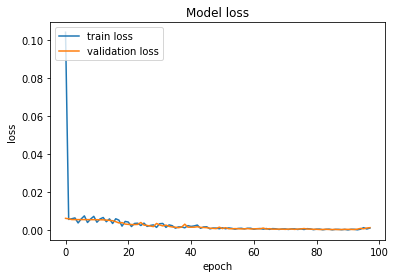

<Figure size 1440x1440 with 0 Axes>

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','validation loss'],loc = 'upper left')
plt.figure(figsize = [20,20])
plt.show()

In [123]:
### Lets Do the prediction and check performance metrics
train_predict=trained_model.predict(x_train_multi)
test_predict=trained_model.predict(x_val_multi)

195/195 [==============================] - 24s 124ms/step


In [124]:
len(test_predict)

6234

In [125]:
len(train_predict)

6234

In [127]:
##Transformback to original form
train_predict = y_scaler.inverse_transform(train_predict)
test_predict = y_scaler.inverse_transform(test_predict)

In [128]:
l = []
for i in train_predict:
    l.append(i[0])

In [129]:
max(l)

14262070000.0

In [130]:
min(l)

272774900.0

In [47]:
test_predict

array([[48619.42  ,  3754.398 ],
       [48620.98  ,  3754.666 ],
       [48621.086 ,  3754.6895],
       ...,
       [48632.75  ,  3756.5452],
       [48631.82  ,  3756.4023],
       [48630.68  ,  3756.2168]], dtype=float32)